# 날씨에 따른 서울 시민의 공공자전거 이용 분석
2023.10.28 ~ 2023.11.18

## 1. 프로젝트 개요

- **주제: 날씨에 따른 서울 시민의 공공자전거 이용 분석**
- 설명: 야외 활동이 어려운 날씨일 때 자전거 이용이 유의미하게 감소하는지 확인
- 사용 데이터셋
    - [서울시 공공자전거 이용현황](https://data.seoul.go.kr/dataList/OA-14994/F/1/datasetView.do) : 서울시에서 운영하는 공공자전거(따릉이)에 대한 기간별, 대여소별 이용(대여, 반납)현황 데이터
    - [방재기상관측(AWS)](https://data.kma.go.kr/data/grnd/selectAwsRltmList.do?pgmNo=56) : 지진 · 태풍 · 홍수 · 가뭄 등 기상현상에 따른 자연재해를 막기 위해 실시하는 지상관측 바람, 습도, 기압 데이터
    - [관측지점정보](https://data.kma.go.kr/tmeta/stn/selectStnList.do) : 기상관측 지점에 대한 지점번호, 관측 시작일과 종료일, 위 · 경도 등 이력정보와 주변 환경 등에 대한 정보

## 2. 데이터 로딩 및 EDA

### 2-1. 서울시 공공자전거 이용현황 API

#### 2-1-1. 데이터 로딩

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import koreanize_matplotlib
import seaborn as sns
from scipy import stats
import pickle
import requests
import json
import math

In [140]:
# 2023년 1월부터 6월까지의 날짜 생성
months = {
    '01': 31, '02': 28, '03': 31, '04': 30, '05': 31, '06': 30
#     '07': 31, '08': 31, '09': 30, '10': 31, '11': 30, '12': 31
}
dates = []

for month, days in months.items():
    for day in range(1, days + 1):
        dates.append(f'2023-{month}-0{str(day)}' if day < 10 else f'2023-{month}-{str(day)}')
        
print(len(dates))

181


181일의 날짜 생성 완료

In [3]:
sum(months.values())

181

날짜 개수가 제대로 생성된 게 맞다.

In [141]:
results = []

# 181일 전체에 대한 데이터 불러오기
for date in dates:
    n = 0 #한 번에 최대 1000개씩 불러올 수 있어서, 여러 번에 나눠서 불러오기 위한 변수
    while True:
        # URL 구성
        url = f'http://openapi.seoul.go.kr:8088'
        params = {
            'key': '73495157686c6f7537384768786b71',
            'type': 'json',
            'service': 'tbCycleUseStatus',
            'start_index': str(n * 1000 + 1),
            'end_index': str((n + 1) * 1000),
            'start_data': date
        }
        for param in params.values():
            url += '/' + param

        # 완성된 URL로부터 데이터 수신
        response = requests.get(url)

        # 받아온 결과를 utf-8 디코딩
        response_data = response.content.decode('utf-8')

        # JSON 문자열을 딕셔너리로 파싱
        response_dict = json.loads(response_data)

        # 결과를 리스트에 저장하고 다음 페이지로 이동
        # 단, 결과가 없는 경우 해당 날짜를 종료
        try:
            results += response_dict['useStatus']['row']
            n += 1
        except:
            break
    
    print(f'{date} 데이터 수신 완료! 현재 데이터 개수 {len(results)}개')

2023-01-01 데이터 수신 완료! 현재 데이터 개수 2630개
2023-01-02 데이터 수신 완료! 현재 데이터 개수 5286개
2023-01-03 데이터 수신 완료! 현재 데이터 개수 7955개
2023-01-04 데이터 수신 완료! 현재 데이터 개수 10631개
2023-01-05 데이터 수신 완료! 현재 데이터 개수 13306개
2023-01-06 데이터 수신 완료! 현재 데이터 개수 15979개
2023-01-07 데이터 수신 완료! 현재 데이터 개수 18630개
2023-01-08 데이터 수신 완료! 현재 데이터 개수 21300개
2023-01-09 데이터 수신 완료! 현재 데이터 개수 23979개
2023-01-10 데이터 수신 완료! 현재 데이터 개수 26661개
2023-01-11 데이터 수신 완료! 현재 데이터 개수 29343개
2023-01-12 데이터 수신 완료! 현재 데이터 개수 32026개
2023-01-13 데이터 수신 완료! 현재 데이터 개수 34603개
2023-01-14 데이터 수신 완료! 현재 데이터 개수 37222개
2023-01-15 데이터 수신 완료! 현재 데이터 개수 39795개
2023-01-16 데이터 수신 완료! 현재 데이터 개수 42472개
2023-01-17 데이터 수신 완료! 현재 데이터 개수 45156개
2023-01-18 데이터 수신 완료! 현재 데이터 개수 47842개
2023-01-19 데이터 수신 완료! 현재 데이터 개수 50527개
2023-01-20 데이터 수신 완료! 현재 데이터 개수 53191개
2023-01-21 데이터 수신 완료! 현재 데이터 개수 55817개
2023-01-22 데이터 수신 완료! 현재 데이터 개수 58417개
2023-01-23 데이터 수신 완료! 현재 데이터 개수 61049개
2023-01-24 데이터 수신 완료! 현재 데이터 개수 63575개
2023-01-25 데이터 수신 완료! 현재 데이터 개수 66223개
2023-01-26 데이터 수신 완료! 현재 데이터

In [142]:
# 데이터프레임 생성
cycle_use_df = pd.DataFrame(results)
cycle_use_df

,STA_LOC,RENT_NM,STAT_DATA,RENT_CNT,RTN_CNT,START_INDEX,END_INDEX
0,양천구,729. 서부식자재마트 건너편,2023-01-01,26,25,0,0
1,양천구,731. 서울시 도로환경관리센터,2023-01-01,38,37,0,0
2,양천구,732. 신월중학교,2023-01-01,22,25,0,0
3,양천구,733. 신정이펜하우스314동,2023-01-01,8,5,0,0
4,양천구,734. 신트리공원 입구,2023-01-01,32,28,0,0
...,...,...,...,...,...,...,...
483143,마포구,426. 서울신용보증재단,2023-06-30,56,55,0,0
483144,양천구,722. 경서농협 버스정류장(우리은행신정동지점방향),2023-06-30,70,71,0,0
483145,양천구,723. SBS방송국,2023-06-30,109,110,0,0
483146,양천구,725. 양강중학교앞 교차로,2023-06-30,42,16,0,0


In [143]:
cycle_use_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 483148 entries, 0 to 483147
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   STA_LOC      483148 non-null  object
 1   RENT_NM      483148 non-null  object
 2   STAT_DATA    483148 non-null  object
 3   RENT_CNT     483148 non-null  object
 4   RTN_CNT      483148 non-null  object
 5   START_INDEX  483148 non-null  int64 
 6   END_INDEX    483148 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 25.8+ MB


데이터를 간략하게 확인해 본 결과
- 각 컬럼의 이름을 **한글로 변경**해야 할 필요성 느낌
- ```START_INDEX```와 ```END_INDEX```는 null값인 것 같으니 삭제해야 함
- ```RENT_CNT```와 ```RTN_CNT```는 str로 들어가 있으니 **int로 변경**해야 함

#### 2-1-2. 데이터 확인 및 전처리 (전체)

In [144]:
# 쓸데없는 컬럼 삭제 및 컬럼 이름 한글화
new_cycle_use_df = cycle_use_df.rename(columns={
    'STA_LOC': '그룹명',
    'RENT_NM': '대여소명',
    'STAT_DATA': '대여년월',
    'RENT_CNT': '대여건수',
    'RTN_CNT': '반납건수'
}).drop(['START_INDEX', 'END_INDEX'], axis=1)

new_cycle_use_df

,그룹명,대여소명,대여년월,대여건수,반납건수
0,양천구,729. 서부식자재마트 건너편,2023-01-01,26,25
1,양천구,731. 서울시 도로환경관리센터,2023-01-01,38,37
2,양천구,732. 신월중학교,2023-01-01,22,25
3,양천구,733. 신정이펜하우스314동,2023-01-01,8,5
4,양천구,734. 신트리공원 입구,2023-01-01,32,28
...,...,...,...,...,...
483143,마포구,426. 서울신용보증재단,2023-06-30,56,55
483144,양천구,722. 경서농협 버스정류장(우리은행신정동지점방향),2023-06-30,70,71
483145,양천구,723. SBS방송국,2023-06-30,109,110
483146,양천구,725. 양강중학교앞 교차로,2023-06-30,42,16


In [145]:
# 대여건수와 반납건수 컬럼을 int로 변경
new_cycle_use_df['대여건수'] = new_cycle_use_df['대여건수'].astype(int)
new_cycle_use_df['반납건수'] = new_cycle_use_df['반납건수'].astype(int)

new_cycle_use_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 483148 entries, 0 to 483147
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   그룹명     483148 non-null  object
 1   대여소명    483148 non-null  object
 2   대여년월    483148 non-null  object
 3   대여건수    483148 non-null  int32 
 4   반납건수    483148 non-null  int32 
dtypes: int32(2), object(3)
memory usage: 14.7+ MB


#### 2-1-3. 데이터 확인 및 전처리 (그룹명)

In [15]:
new_cycle_use_df['그룹명'].nunique()

25

In [16]:
new_cycle_use_df['그룹명'].unique()

array(['양천구', '광진구', '은평구', '성동구', '강동구', '강서구', '송파구', '중랑구', '마포구',
       '강북구', '노원구', '도봉구', '금천구', '동작구', '관악구', '서초구', '중구', '종로구',
       '강남구', '서대문구', '성북구', '구로구', '동대문구', '영등포구', '용산구'], dtype=object)

25개 행정구에 대한 데이터임을 확인

In [17]:
# 행정구별 행 개수 확인
rows_by_group = new_cycle_use_df['그룹명'].value_counts().sort_values(ascending=False).to_frame()

rows_by_group

,그룹명
송파구,38460
강서구,33103
강남구,29223
영등포구,26757
서초구,25043
노원구,24329
마포구,21482
강동구,21441
구로구,19955
양천구,19533


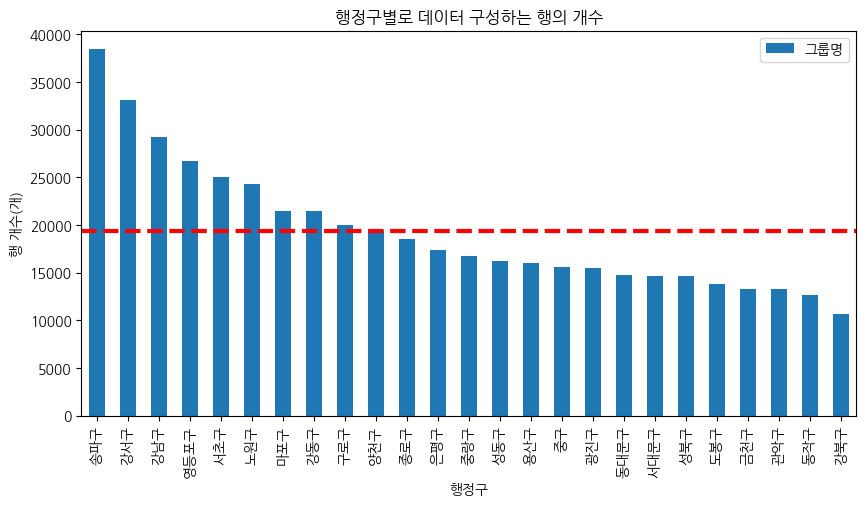

In [18]:
# 시각화
rows_by_group.plot(kind='bar', figsize=(10, 5))
plt.title('행정구별로 데이터 구성하는 행의 개수')
plt.xlabel('행정구')
plt.ylabel('행 개수(개)')
plt.axhline(rows_by_group.mean().values[0], color='red', linestyle='--', linewidth='3')
plt.show()

데이터 개수가 평균보다 많은 곳은 **송파구, 강서구, 강남구, 영등포구, 서초구, 노원구, 마포구, 강동구, 구로구, 양천구**

In [19]:
rows_by_group.loc['양천구'].values[0] > rows_by_group.mean().values[0]

True

사실 양천구는 아리까리해서 직접 확인해봤다

In [21]:
# 행정구별 총 대여건수와 총 반납건수 확인
sum_by_group = new_cycle_use_df.groupby('그룹명').agg({'대여건수': 'sum', '반납건수': 'sum'})
sum_by_group['합계'] = sum_by_group['대여건수'] + sum_by_group['반납건수']
sum_by_group = sum_by_group.sort_values('합계', ascending=False)
sum_by_group

,대여건수,반납건수,합계
그룹명,,,
강서구,2425742,2408730,4834472
송파구,2019359,2001083,4020442
영등포구,1756829,1717698,3474527
노원구,1306650,1294840,2601490
양천구,1221741,1220666,2442407
마포구,1066569,1066762,2133331
광진구,1053185,1032267,2085452
강동구,933894,939209,1873103
성동구,864134,855186,1719320


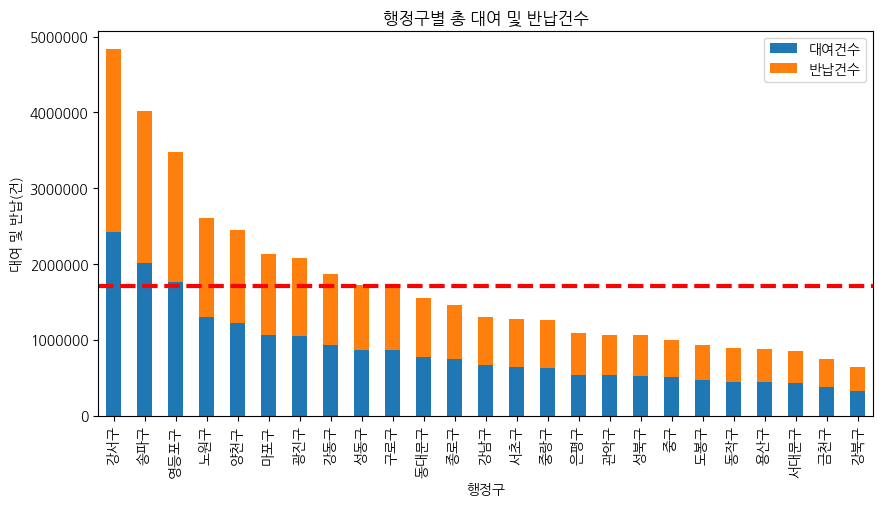

In [22]:
# 시각화
sum_by_group[['대여건수', '반납건수']].plot(kind='bar', figsize=(10, 5), stacked=True)
plt.title('행정구별 총 대여 및 반납건수')
plt.xlabel('행정구')
plt.ylabel('대여 및 반납(건)')
plt.ticklabel_format(axis='y',useOffset=False, style='plain')
plt.axhline(sum_by_group['합계'].mean(), color='red', linestyle='--', linewidth='3')
plt.show()

In [23]:
sum_by_group.loc['성동구', '합계'] > sum_by_group['합계'].mean()

True

In [24]:
sum_by_group.loc['구로구', '합계'] > sum_by_group['합계'].mean()

False

총 대여 및 반납건수가 평균 이상인 곳은 **강서구, 송파구, 영등포구, 노원구, 양천구, 마포구, 광진구, 강동구, 성동구**

#### 2-1-4. 데이터 확인 및 전처리 (대여소명)

In [25]:
# 대여소 개수
new_cycle_use_df['대여소명'].nunique()

2739

대여소 종류가 2739개나 된다.

In [26]:
# 행정구별 대여소 개수 
station_in_group = new_cycle_use_df.groupby('그룹명').agg({'대여소명': 'nunique'}).sort_values('대여소명', ascending=False)
station_in_group

,대여소명
그룹명,
송파구,218
강서구,187
강남구,166
영등포구,151
서초구,147
노원구,137
강동구,122
마포구,122
구로구,114


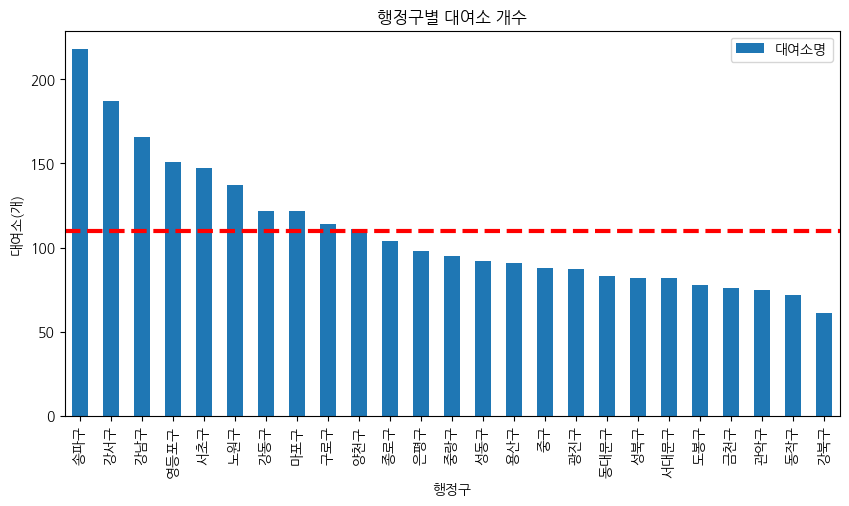

In [27]:
# 시각화
station_in_group.plot(kind='bar', figsize=(10, 5))
plt.title('행정구별 대여소 개수')
plt.xlabel('행정구')
plt.ylabel('대여소(개)')
plt.axhline(station_in_group.mean().values[0], color='red', linestyle='--', linewidth='3')
plt.show()

어디서 본 그래프 같네...? 사실 날짜별로 대여소마다의 데이터가 구성되어 있을 테니 행의 개수가 곧 대여소 개수였을 것이다...!

In [28]:
# 한강공원이 들어가는 대여소 개수 확인
new_cycle_use_df[new_cycle_use_df['대여소명'].str.contains('한강공원')]['대여소명'].unique()

array(['4217. 한강공원 망원나들목'], dtype=object)

In [29]:
new_cycle_use_df[new_cycle_use_df['대여소명'].str.contains('유원지')]['대여소명'].unique()

array(['588. 뚝섬 유원지역', '502. 뚝섬유원지역 1번출구 앞'], dtype=object)

In [30]:
new_cycle_use_df[new_cycle_use_df['대여소명'].str.contains('선착장')]['대여소명'].unique()

array(['260. 여의도 마리나선착장 앞'], dtype=object)

In [31]:
new_cycle_use_df[new_cycle_use_df['대여소명'].str.contains('나루')]['대여소명'].unique()

array(['1296. 석촌호수교차로 (송파나루근린공원 앞)',
       '1191. 마곡역 버스정류장(마곡나루역1번출구, 웰튼병원 방면)', '2701. 마곡나루역 5번출구 뒤편',
       '2620. 송파나루역 4번 출구옆', '2715.마곡나루역 2번 출구 ', '2728.마곡나루역 3번 출구',
       '119. 서강나루 공원', '3564.나루마당', '3573.광나루안전체험관', '4484. 잠실나루역4번출구뒤',
       '4485. 잠실나루역 고가하부', '4859. 잠실나루 나들목', '576. 광나루역 3번 출구',
       '1004. 삼성광나루아파트 버스정류장', '1209. 잠실나루역 (2번 출구 쪽)',
       '207. 여의나루역 1번출구 앞'], dtype=object)

In [95]:
new_cycle_use_df[new_cycle_use_df['대여소명'].str.contains('대여소')]['대여소명'].unique()

array(['1153. 발산역 1번, 9번 인근 대여소', '2612. 문정·가락 대여소 앞', '4594. 양평교 영등포대여소',
       '1634. 당고개공원 대여소', '1635. 상계3.4동 주민센터 대여소'], dtype=object)

대여소 이름으로부터 **한강공원과 관련 있는 데이터**를 뽑아낼 방법은 더 생각해 봐야 할 듯

#### 2-1-5. 데이터 확인 및 전처리 (대여년월)

In [146]:
len(dates)

181

181일 모두 제대로 불러와졌는지 확인하기

In [147]:
new_cycle_use_df['대여년월'].nunique()

180

In [34]:
new_cycle_use_df['대여년월'].nunique() == len(dates)

False

뭔가 문제가 있는 것 같으니 직접 확인해보자

In [148]:
for date in dates:
    if date not in new_cycle_use_df['대여년월'].unique():
        print(date)

2023-06-26


**2023년 6월 26일이 누락**되어 있다

#### 2-1-6. 데이터 확인 및 전처리 (대여건수, 반납건수)

정수형 데이터들이니까 분포를 보자.

In [36]:
new_cycle_use_df[['대여건수', '반납건수']].describe()

,대여건수,반납건수
count,483148.000000,483148.000000
mean,44.678602,44.129946
std,49.864576,51.623134
min,0.000000,0.000000
25%,13.000000,11.750000
50%,30.000000,28.000000
75%,59.000000,59.000000
max,1384.000000,1573.000000


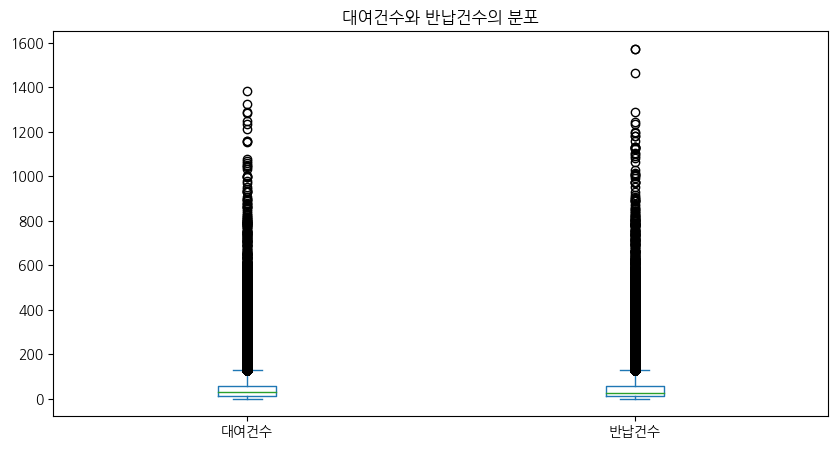

In [37]:
new_cycle_use_df[['대여건수', '반납건수']].plot(kind='box', figsize=(10, 5))
plt.title('대여건수와 반납건수의 분포')
plt.show()

대략 30~40건 내외가 일반적인 것 같다.

그런데 하루 동안 대여소에서 1384건의 대여와 1573건의 반납이 발생하는 경우가 있다고...?

In [38]:
new_cycle_use_df[new_cycle_use_df['대여건수'] == 1384]

,그룹명,대여소명,대여년월,대여건수,반납건수
245492,마포구,4217. 한강공원 망원나들목,2023-04-02,1384,1573


4월 2일 한강공원 망원나들목이라고 한다. 날이 좋을수록 한강공원을 많이 이용하지 않을까 하는 문제 정의에 완벽히 부합하는 예시가 나왔다!

#### 2-1-7. 데이터프레임 저장

In [149]:
new_cycle_use_df

,그룹명,대여소명,대여년월,대여건수,반납건수
0,양천구,729. 서부식자재마트 건너편,2023-01-01,26,25
1,양천구,731. 서울시 도로환경관리센터,2023-01-01,38,37
2,양천구,732. 신월중학교,2023-01-01,22,25
3,양천구,733. 신정이펜하우스314동,2023-01-01,8,5
4,양천구,734. 신트리공원 입구,2023-01-01,32,28
...,...,...,...,...,...
483143,마포구,426. 서울신용보증재단,2023-06-30,56,55
483144,양천구,722. 경서농협 버스정류장(우리은행신정동지점방향),2023-06-30,70,71
483145,양천구,723. SBS방송국,2023-06-30,109,110
483146,양천구,725. 양강중학교앞 교차로,2023-06-30,42,16


In [150]:
with open('new_cycle_use_df.pkl', 'wb') as file:
    pickle.dump(new_cycle_use_df, file)
    print("저장 완료")

저장 완료


### 2-2. 방재기상관측(AWS) 데이터

#### 2-3-1. 데이터 로딩

In [2]:
weather_df = pd.read_csv('OBS_AWS_TIM_20231106144425.csv', encoding='cp949')
weather_df

,지점,지점명,일시,기온(°C),풍향(deg),풍속(m/s),강수량(mm),현지기압(hPa),해면기압(hPa),습도(%)
0,116,관악(레),2023-01-01 00:00,-1.7,248.1,4.4,0.0,NaN,NaN,76.0
1,116,관악(레),2023-01-01 01:00,-1.6,248.6,4.3,0.0,NaN,NaN,76.0
2,116,관악(레),2023-01-01 02:00,-1.5,255.2,4.8,0.0,NaN,NaN,82.0
3,116,관악(레),2023-01-01 03:00,-1.6,275.4,3.6,0.0,NaN,NaN,87.0
4,116,관악(레),2023-01-01 04:00,-2.5,331.7,3.8,0.0,NaN,NaN,91.0
...,...,...,...,...,...,...,...,...,...,...
121614,889,현충원,2023-06-30 19:00,28.2,209.4,0.7,0.0,998.7,1000.5,89.0
121615,889,현충원,2023-06-30 20:00,25.8,0.0,0.4,0.0,999.4,1001.2,98.0
121616,889,현충원,2023-06-30 21:00,24.8,0.0,0.3,0.0,1000.0,1001.8,100.0
121617,889,현충원,2023-06-30 22:00,24.2,0.0,0.2,0.0,1000.7,1002.5,100.0


In [50]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121619 entries, 0 to 121618
Data columns (total 10 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   지점         121619 non-null  int64  
 1   지점명        121619 non-null  object 
 2   일시         121619 non-null  object 
 3   기온(°C)     121411 non-null  float64
 4   풍향(deg)    121507 non-null  float64
 5   풍속(m/s)    121543 non-null  float64
 6   강수량(mm)    121126 non-null  float64
 7   현지기압(hPa)  73829 non-null   float64
 8   해면기압(hPa)  73823 non-null   float64
 9   습도(%)      112821 non-null  float64
dtypes: float64(7), int64(1), object(2)
memory usage: 9.3+ MB


데이터 모양을 살펴본 결과
- 관측 지점과 대여소 간의 매핑 필요
- 일시는 날짜(yyyy-mm-dd)에 더해 **시간(hh:mm) 단위로 들어가 있음** → 추후 일 단위로 집계 필요할 수 있음
- 풍향(deg), 현지기압(hPa), 해면기압(hPa) 컬럼은 안 쓰일 듯

In [3]:
dropped_weather_df = weather_df.drop([
    '풍향(deg)', '현지기압(hPa)', '해면기압(hPa)' 
], axis=1)

dropped_weather_df

,지점,지점명,일시,기온(°C),풍속(m/s),강수량(mm),습도(%)
0,116,관악(레),2023-01-01 00:00,-1.7,4.4,0.0,76.0
1,116,관악(레),2023-01-01 01:00,-1.6,4.3,0.0,76.0
2,116,관악(레),2023-01-01 02:00,-1.5,4.8,0.0,82.0
3,116,관악(레),2023-01-01 03:00,-1.6,3.6,0.0,87.0
4,116,관악(레),2023-01-01 04:00,-2.5,3.8,0.0,91.0
...,...,...,...,...,...,...,...
121614,889,현충원,2023-06-30 19:00,28.2,0.7,0.0,89.0
121615,889,현충원,2023-06-30 20:00,25.8,0.4,0.0,98.0
121616,889,현충원,2023-06-30 21:00,24.8,0.3,0.0,100.0
121617,889,현충원,2023-06-30 22:00,24.2,0.2,0.0,100.0


In [55]:
dropped_weather_df.isna().sum()

지점            0
지점명           0
일시            0
기온(°C)      208
풍속(m/s)      76
강수량(mm)     493
습도(%)      8798
dtype: int64

데이터가 누락된 경우에 대한 처리는
- 기온, 풍속, 습도: 이전 데이터와 다음 데이터 사이의 linear interpolation으로 하면 되지 않을까?
- 강수량: 0으로 넣는 게 낫지 않을까?

자세한 건 데이터 모양 직접 보면서 고민하기

#### 2-3-2. 데이터 확인 및 전처리 (지점, 지점명)

In [73]:
dropped_weather_df['지점'].unique()

array([116, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411,
       412, 413, 414, 415, 416, 417, 418, 419, 421, 423, 424, 425, 509,
       510, 889], dtype=int64)

In [74]:
dropped_weather_df['지점명'].unique()

array(['관악(레)', '강남', '서초', '강동', '송파', '강서', '양천', '도봉', '노원', '동대문',
       '중랑', '기상청', '마포', '서대문', '광진', '성북', '용산', '은평', '금천', '한강', '중구',
       '성동', '구로', '강북', '남현', '관악', '영등포 ', '현충원'], dtype=object)

#### 2-3-3. 데이터 확인 및 전처리 (일시)

In [75]:
dropped_weather_df['일시']

0         2023-01-01 00:00
1         2023-01-01 01:00
2         2023-01-01 02:00
3         2023-01-01 03:00
4         2023-01-01 04:00
                ...       
121614    2023-06-30 19:00
121615    2023-06-30 20:00
121616    2023-06-30 21:00
121617    2023-06-30 22:00
121618    2023-06-30 23:00
Name: 일시, Length: 121619, dtype: object

날짜와 시간을 분리하여 파생 컬럼 만들 필요 있을 것 같다.

In [4]:
dropped_weather_df['날짜'] = dropped_weather_df['일시'].str.split(' ').str[0]
dropped_weather_df['시간'] = dropped_weather_df['일시'].str.split(' ').str[1]
dropped_weather_df

,지점,지점명,일시,기온(°C),풍속(m/s),강수량(mm),습도(%),날짜,시간
0,116,관악(레),2023-01-01 00:00,-1.7,4.4,0.0,76.0,2023-01-01,00:00
1,116,관악(레),2023-01-01 01:00,-1.6,4.3,0.0,76.0,2023-01-01,01:00
2,116,관악(레),2023-01-01 02:00,-1.5,4.8,0.0,82.0,2023-01-01,02:00
3,116,관악(레),2023-01-01 03:00,-1.6,3.6,0.0,87.0,2023-01-01,03:00
4,116,관악(레),2023-01-01 04:00,-2.5,3.8,0.0,91.0,2023-01-01,04:00
...,...,...,...,...,...,...,...,...,...
121614,889,현충원,2023-06-30 19:00,28.2,0.7,0.0,89.0,2023-06-30,19:00
121615,889,현충원,2023-06-30 20:00,25.8,0.4,0.0,98.0,2023-06-30,20:00
121616,889,현충원,2023-06-30 21:00,24.8,0.3,0.0,100.0,2023-06-30,21:00
121617,889,현충원,2023-06-30 22:00,24.2,0.2,0.0,100.0,2023-06-30,22:00


#### 2-3-4. 데이터 확인 및 전처리 (기온)

In [49]:
dropped_weather_df['기온(°C)'].describe()

count    121411.000000
mean         11.005864
std           9.928642
min         -22.100000
25%           3.100000
50%          11.300000
75%          19.300000
max          34.900000
Name: 기온(°C), dtype: float64

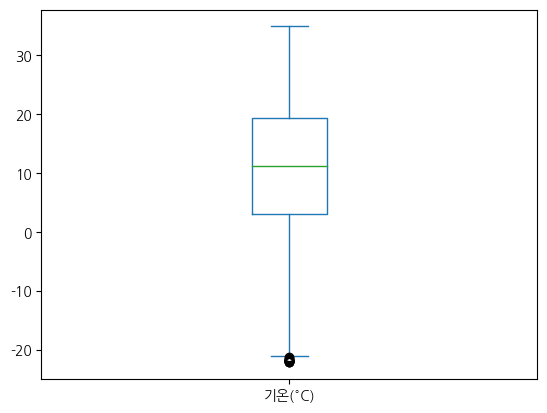

In [50]:
dropped_weather_df['기온(°C)'].plot(kind='box')
plt.show()

대략 5도 근방에서 20도 정도까지에 데이터들이 몰려있는 것 같다. 이상치로 영하 20도 이하의 데이터도 있다!

#### 2-3-5. 데이터 확인 및 전처리 (바람)

In [51]:
dropped_weather_df['풍속(m/s)'].describe()

count    121543.000000
mean          1.652618
std           1.124294
min           0.000000
25%           0.800000
50%           1.500000
75%           2.200000
max          10.900000
Name: 풍속(m/s), dtype: float64

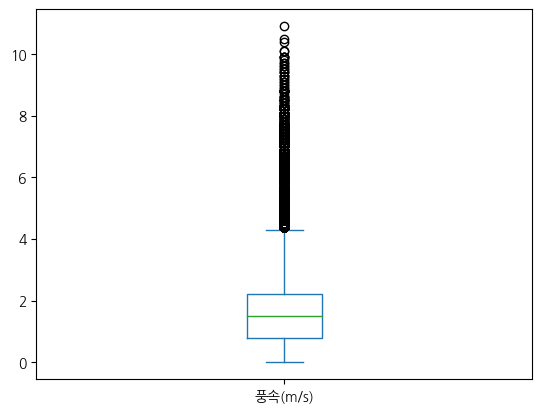

In [52]:
dropped_weather_df['풍속(m/s)'].plot(kind='box')
plt.show()

풍속은 대체로 잔잔한 편인 경우가 많지만 좀 바람이 세게 불면 그게 다 이상치로 측정되는 모양이다.

#### 2-3-6. 데이터 확인 및 전처리 (비)

In [85]:
dropped_weather_df[dropped_weather_df['강수량(mm)'] > 0].count()

지점         5574
지점명        5574
일시         5574
기온(°C)     5565
풍속(m/s)    5573
강수량(mm)    5574
습도(%)      5202
날짜         5574
시간         5574
dtype: int64

비가 왔는지 안 왔는지를 표현해 주는 컬럼이 필요할 듯하다.

In [5]:
dropped_weather_df['강수여부'] = dropped_weather_df['강수량(mm)'].apply(
    lambda x:1 if x > 0 else 0
)

dropped_weather_df[dropped_weather_df['강수여부'] == 1]

,지점,지점명,일시,기온(°C),풍속(m/s),강수량(mm),습도(%),날짜,시간,강수여부
143,116,관악(레),2023-01-06 23:00,NaN,8.2,1.0,98.0,2023-01-06,23:00,1
289,116,관악(레),2023-01-13 01:00,4.7,5.9,1.0,77.0,2023-01-13,01:00,1
290,116,관악(레),2023-01-13 02:00,3.4,3.2,4.0,97.0,2023-01-13,02:00,1
291,116,관악(레),2023-01-13 03:00,4.7,7.2,6.0,98.0,2023-01-13,03:00,1
292,116,관악(레),2023-01-13 04:00,5.4,9.2,1.5,98.0,2023-01-13,04:00,1
...,...,...,...,...,...,...,...,...,...,...
121587,889,현충원,2023-06-29 16:00,23.3,0.5,16.0,100.0,2023-06-29,16:00,1
121590,889,현충원,2023-06-29 19:00,24.3,2.0,0.5,100.0,2023-06-29,19:00,1
121591,889,현충원,2023-06-29 20:00,24.1,1.6,0.5,100.0,2023-06-29,20:00,1
121592,889,현충원,2023-06-29 21:00,24.0,1.5,0.5,100.0,2023-06-29,21:00,1


#### 2-3-7. 데이터 확인 및 전처리 (습도)

In [53]:
dropped_weather_df['습도(%)'].describe()

count    112821.000000
mean         58.098466
std          22.521124
min           5.000000
25%          40.000000
50%          57.000000
75%          76.000000
max         100.000000
Name: 습도(%), dtype: float64

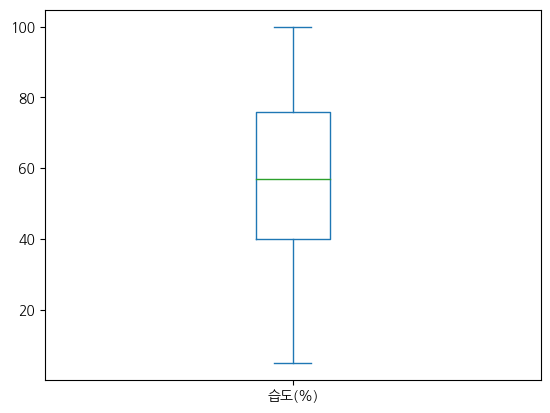

In [54]:
dropped_weather_df['습도(%)'].plot(kind='box')
plt.show()

습도는 40~80% 범위에서 예쁘게 분포되어 있다.

#### 2-3-8. 파생 변수 생성 (체감온도)

체감온도는 인간이 느끼는 더위나 추위를 수량적으로 나타내는 지표이다. 본 분석에서 '날씨가 좋을 때'를 나타내는 파생 지표로써 활용하기에 정말 좋을 것으로 보인다. 기상청에서는 동절기(10월\~4월), 하절기(5월\~9월)를 구분하여 체감온도를 산출한다.

$$T_{wcs} = -0.2442 + 0.55399T_w + 0.45535T_a – 0.0022{T_w}^2 + 0.00278T_wT_a + 3.0$$
$$T_{wcw} = 13.12 + 0.6215T_a - 11.37V^{0.16} + 0.3965V^{0.16}T_a$$

이때 $T_{wcs}$: 여름철 체감온도, $T_{wcw}$: 겨울철 체감온도, $T_a$: 기온(°C), $T_w$: 습구온도(Stull의 추정식 이용), $RH$: 상대습도(%), $V$: 10분 평균 풍속(km/h)이다. 겨울철 체감온도는 기온 10°C 이하, 풍속 1.3 m/s 이상일 때에만 산출한다.

습구온도($T_w$)를 구하기 위한 [Stull의 추정식](https://open.library.ubc.ca/media/stream/pdf/52383/1.0041967/1)[1]은 아래와 같다.

$$T_w = T_a{tan}^{-1}(0.151977(RH+8.313659)^{0.5})+{tan}^{-1}(T_a+RH)-{tan}^{-1}(RH-1.67633)$$
$$+{0.00391838RH}^{1.5}{tan}^{-1}(0.023101RH)-4.686035$$

이상의 공식을 활용하여, 체감온도 파생 변수를 만들고 이를 이용해 분석을 진행해 보도록 한다.

---
[1] Stull, R. (2011). Wet-bulb temperature from relative humidity and air temperature. *J. Appl. Meteorol. Climatol.*, Vol. 50, pp.2267-2269.

In [6]:
def get_tw(ta, rh):
    '''
    Stull의 추정식을 이용하여, 온도와 습도로부터 습구온도를 계산하는 함수
    '''
    tw = ta * math.atan(0.151977 * ((rh + 8.313659) ** 0.5))
    tw += math.atan(ta + rh)
    tw -= math.atan(rh - 1.67633)
    tw += (0.00391838 * (rh ** 1.5) * math.atan(0.023101 * rh))
    tw -= 4.686035
    return tw

def get_summer_twc(ta, rh):
    '''
    온도, 습도를 통해 여름철의 체감온도를 계산하는 함수
    '''
    tw = get_tw(ta, rh) 
    twcs = -0.2442 + (0.55399 * tw) + (0.45535 * ta) - (0.0022 * (tw ** 2)) + (0.00278 * tw * ta) + 3.0
    return twcs

def get_winter_twc(ta, v):
    '''
    온도, 풍속을 통해 겨울철의 체감온도를 계산하는 함수
    '''
    if ta <= 10 and v >= 1.3:
        twcw = 13.12 + (0.6215 * ta) - (11.37 * (v ** 0.16)) + (0.3965 * (v ** 0.16) * ta)
    else:
        twcw = ta
    return min(twcw, ta)

def get_twc(row):
    '''
    데이터프레임 한 줄을 받았을 때 해당 줄의 체감온도를 알아서 계산해 주는 함수
    '''
    month = row['날짜'].split('-')[1]
    ta, v, rh = row['기온(°C)'], row['풍속(m/s)'], row['습도(%)']
    
    if month in ['05', '06', '07', '08', '09']:
        return get_summer_twc(ta, rh)
    else:
        return get_winter_twc(ta, v)

제대로 작동되는지 테스트해보자.

In [90]:
# 테스트해보기
print("여름철:", get_summer_twc(28.6, 85))
print("겨울철:", get_winter_twc(9.4, 6.1))

여름철: 31.030348083019742
겨울철: 8.754798314643951


기상청 날씨누리에서 임의 데이터 하나 긁어서 넣은 건데, **여름철은 제대로 나오고**, 겨울철은 조금 고민이 필요하다. 일단 함수는 잘 작동하는데, 다만 데이터에서 제공되는 게 1시간 평균 풍속이기 때문이다. 체감온도에 10분 평균 풍속을 넣어야 해서 조금 부정확한 결과가 나올 수 있다.

In [7]:
dropped_weather_df['체감온도'] = dropped_weather_df.apply(get_twc, axis=1)
dropped_weather_df

,지점,지점명,일시,기온(°C),풍속(m/s),강수량(mm),습도(%),날짜,시간,강수여부,체감온도
0,116,관악(레),2023-01-01 00:00,-1.7,4.4,0.0,76.0,2023-01-01,00:00,0,-3.202540
1,116,관악(레),2023-01-01 01:00,-1.6,4.3,0.0,76.0,2023-01-01,01:00,0,-3.034268
2,116,관악(레),2023-01-01 02:00,-1.5,4.8,0.0,82.0,2023-01-01,02:00,0,-3.190334
3,116,관악(레),2023-01-01 03:00,-1.6,3.6,0.0,87.0,2023-01-01,03:00,0,-2.609357
4,116,관악(레),2023-01-01 04:00,-2.5,3.8,0.0,91.0,2023-01-01,04:00,0,-3.738554
...,...,...,...,...,...,...,...,...,...,...,...
121614,889,현충원,2023-06-30 19:00,28.2,0.7,0.0,89.0,2023-06-30,19:00,0,30.914765
121615,889,현충원,2023-06-30 20:00,25.8,0.4,0.0,98.0,2023-06-30,20:00,0,29.069218
121616,889,현충원,2023-06-30 21:00,24.8,0.3,0.0,100.0,2023-06-30,21:00,0,28.166841
121617,889,현충원,2023-06-30 22:00,24.2,0.2,0.0,100.0,2023-06-30,22:00,0,27.542044


In [116]:
dropped_weather_df['체감온도'].isna().sum()

3185

잘 들어간 것 같다.

In [55]:
dropped_weather_df['체감온도'].describe()

count    118434.000000
mean         10.922377
std          10.186006
min         -27.880532
25%           2.847579
50%          11.055580
75%          20.000000
max          33.622093
Name: 체감온도, dtype: float64

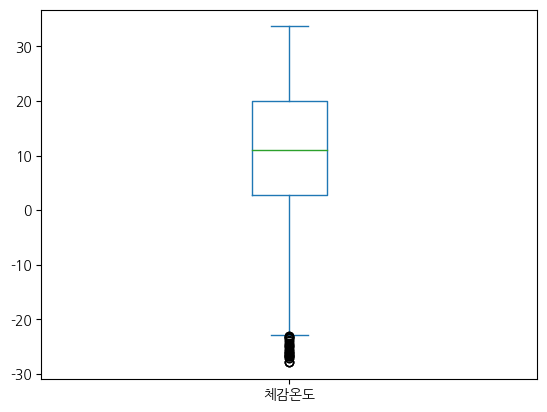

In [56]:
dropped_weather_df['체감온도'].plot(kind='box')
plt.show()

진짜 추운 날에는 영하 30도 근처까지 내려간다. 날도 춥고 칼바람 쌩쌩 부는 날인 모양이다.

#### 2-3-9. 일 단위로 집계

In [8]:
weather_daily_df = dropped_weather_df.groupby(['날짜', '지점'], as_index=False).agg({
    '강수여부': 'sum', '체감온도': 'mean', '기온(°C)': 'mean', '풍속(m/s)': 'mean'
})

weather_daily_df

,날짜,지점,강수여부,체감온도,기온(°C),풍속(m/s)
0,2023-01-01,116,0,-5.883430,-3.883333,4.895833
1,2023-01-01,400,0,0.901465,0.937500,1.525000
2,2023-01-01,401,0,0.964879,1.112500,2.141667
3,2023-01-01,402,0,0.291667,0.291667,1.025000
4,2023-01-01,403,0,1.287787,1.416667,2.020833
...,...,...,...,...,...,...
5063,2023-06-30,424,2,27.284616,24.791667,0.579167
5064,2023-06-30,425,1,26.947587,24.237500,0.658333
5065,2023-06-30,509,2,26.707166,24.126087,1.304167
5066,2023-06-30,510,1,28.194553,26.054167,0.979167


매번 여러 개 컬럼을 동시에 묶어서 groupby 할 때마다 멀티인덱스 때문에 짜증났었는데!! ```as_index = False```로 주면 **멀티인덱스가 안 생긴다**는 꿀팁을 알게 됐다...! 유레카다 유레카

#### 2-3-10. 위치 데이터 매핑

In [9]:
# 위치 정보를 담은 csv 파일 불러오기
weather_pos_df = pd.read_csv('META_관측지점정보_20231106165559.csv', encoding='cp949')
weather_pos_df

,지점,시작일,종료일,지점명,지점주소,관리관서,위도,경도,노장해발고도(m),기압계(관측장비지상높이(m)),기온계(관측장비지상높이(m)),풍속계(관측장비지상높이(m)),강우계(관측장비지상높이(m))
0,400,2020-10-23,NaN,강남,서울특별시 강남구일원동 580탄천 물재생센터,NaN,37.4982,127.0817,10.32,NaN,NaN,NaN,NaN
1,400,2019-05-29,2020-10-23,강남,서울특별시 강남구일원동 580탄천 물재생센터,NaN,37.4982,127.0816,28.70,NaN,NaN,NaN,NaN
2,400,2010-08-16,2019-05-29,강남,서울특별시 강남구일원동 580탄천 물재생센터,NaN,37.5134,127.0467,59.24,NaN,NaN,NaN,NaN
3,400,1994-12-04,2010-08-15,강남,서울특별시 강남구일원동 580탄천 물재생센터,서울기상관측소(108),37.5094,127.0485,59.00,NaN,NaN,NaN,NaN
4,401,2022-09-23,NaN,서초,서울특별시 서초구서초동 1416번지서초 IC,NaN,37.4846,127.0260,33.05,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,509,1992-09-14,2004-09-04,관악,서울특별시 관악구관악로 1서울대학교 대기환경관측소,서울기상관측소(108),37.4562,126.9507,92.36,NaN,NaN,NaN,NaN
79,510,2021-08-26,NaN,영등포,서울특별시 영등포구국회대로53길 20서울영동초등학교,NaN,37.5271,126.9071,25.38,NaN,NaN,NaN,NaN
80,510,2010-08-16,2021-08-26,영등포,서울특별시 영등포구국회대로53길 20서울영동초등학교,NaN,37.5271,126.9071,25.38,NaN,NaN,NaN,NaN
81,510,1989-06-27,2010-08-15,영등포,서울특별시 영등포구국회대로53길 20서울영동초등학교,서울기상관측소(108),37.5262,126.9080,25.00,NaN,NaN,NaN,NaN


쓸모없는 컬럼들이 보인다. 요긴하게 쓰일 컬럼은 지점, 종료일, 지점주소 정도일 것 같고 그 외에 정말 안 쓰일 것 같은 컬럼들은 드랍하는 게 유리하겠다.

In [16]:
dropped_weather_pos_df = weather_pos_df.drop([
    '관리관서', '노장해발고도(m)', '기압계(관측장비지상높이(m))', '기온계(관측장비지상높이(m))',
    '풍속계(관측장비지상높이(m))', '강우계(관측장비지상높이(m))'
], axis=1)

dropped_weather_pos_df

,지점,시작일,종료일,지점명,지점주소,위도,경도
0,400,2020-10-23,NaN,강남,서울특별시 강남구일원동 580탄천 물재생센터,37.4982,127.0817
1,400,2019-05-29,2020-10-23,강남,서울특별시 강남구일원동 580탄천 물재생센터,37.4982,127.0816
2,400,2010-08-16,2019-05-29,강남,서울특별시 강남구일원동 580탄천 물재생센터,37.5134,127.0467
3,400,1994-12-04,2010-08-15,강남,서울특별시 강남구일원동 580탄천 물재생센터,37.5094,127.0485
4,401,2022-09-23,NaN,서초,서울특별시 서초구서초동 1416번지서초 IC,37.4846,127.0260
...,...,...,...,...,...,...,...
78,509,1992-09-14,2004-09-04,관악,서울특별시 관악구관악로 1서울대학교 대기환경관측소,37.4562,126.9507
79,510,2021-08-26,NaN,영등포,서울특별시 영등포구국회대로53길 20서울영동초등학교,37.5271,126.9071
80,510,2010-08-16,2021-08-26,영등포,서울특별시 영등포구국회대로53길 20서울영동초등학교,37.5271,126.9071
81,510,1989-06-27,2010-08-15,영등포,서울특별시 영등포구국회대로53길 20서울영동초등학교,37.5262,126.9080


주소로부터 구를 추출한 파생 컬럼을 만들어 두면 추후 조인에 유리할 것이다.

In [120]:
dropped_weather_pos_df['지점주소'].isna().sum()

2

주소가 결측치인 건 신박한데...? 걔네들은 제외할 필요가 있겠다. 그리고 종료일이 기재되어 있는 지점은 현재 운영이 안 되고 있을 것이므로 **종료일이 결측치인 컬럼**만을 취해야만 한다.

In [17]:
weather_cur_pos_df = dropped_weather_pos_df[
    (dropped_weather_pos_df['지점주소'].notna()) & (dropped_weather_pos_df['종료일'].isna())
][['지점', '지점주소', '위도', '경도']].reset_index(drop=True)

weather_cur_pos_df

,지점,지점주소,위도,경도
0,400,서울특별시 강남구일원동 580탄천 물재생센터,37.4982,127.0817
1,401,서울특별시 서초구서초동 1416번지서초 IC,37.4846,127.0260
2,402,서울특별시 강동구고덕로 183서울종합직업전문학교,37.5555,127.1450
3,403,서울특별시 송파구올림픽로 240롯데월드,37.5115,127.0967
4,404,서울특별시 강서구양천로 201서남물재생센터,37.5739,126.8295
5,405,서울특별시 양천구 안양천로 917목동빗물펌프장(목동),37.5282,126.8794
6,406,서울특별시 도봉구시루봉로 173신방학초등학교,37.6661,127.0295
7,407,서울특별시 노원구공릉동 사서함 230-3호 사서함 77호 육군사관학교,37.6219,127.0919
8,408,서울특별시 동대문구서울시립대로 163 서울시립대학교 창공관,37.5846,127.0604
9,409,서울특별시 중랑구면목로57길 32면동초등학교,37.5855,127.0868


In [18]:
def process_address(txt):
    '''
    주소를 받아서 구를 반환하는 함수
    '''
    new_txt = txt.split(' ')[1]
    for i in range(1, 4):
        if new_txt[i] == '구':
            return new_txt[:(i + 1)]
    return None

weather_cur_pos_df['그룹명'] = weather_cur_pos_df['지점주소'].apply(process_address)
weather_cur_pos_df['그룹명'].value_counts()

관악구     2
영등포구    2
동작구     2
광진구     1
강북구     1
구로구     1
성동구     1
중구      1
금천구     1
은평구     1
용산구     1
성북구     1
강남구     1
서초구     1
마포구     1
중랑구     1
동대문구    1
노원구     1
도봉구     1
양천구     1
강서구     1
송파구     1
강동구     1
서대문구    1
Name: 그룹명, dtype: int64

관악구, 영등포구, 동작구는 **지점이 2개씩** 있어서 추후 처리가 필요할 듯하다.

아무튼 이제 관측 데이터와 지점 데이터를 합칠 수 있다.

In [19]:
merged_weather_df = pd.merge(
    left=weather_daily_df,
    right=weather_cur_pos_df,
    how='outer',
    on='지점'
)

merged_weather_df

,날짜,지점,강수여부,체감온도,기온(°C),풍속(m/s),지점주소,위도,경도,그룹명
0,2023-01-01,116,0,-5.883430,-3.883333,4.895833,NaN,NaN,NaN,NaN
1,2023-01-02,116,0,-10.341636,-8.691667,3.566667,NaN,NaN,NaN,NaN
2,2023-01-03,116,0,-9.887621,-7.808333,4.287500,NaN,NaN,NaN,NaN
3,2023-01-04,116,0,-5.179025,-4.766667,2.229167,NaN,NaN,NaN,NaN
4,2023-01-05,116,0,-4.087618,-3.550000,2.583333,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
5063,2023-06-26,889,11,27.503134,24.691667,1.262500,서울특별시 동작구현충로 210국립서울현충원,37.5004,126.9765,동작구
5064,2023-06-27,889,2,27.848212,25.895833,1.758333,서울특별시 동작구현충로 210국립서울현충원,37.5004,126.9765,동작구
5065,2023-06-28,889,0,29.147872,26.745833,1.354167,서울특별시 동작구현충로 210국립서울현충원,37.5004,126.9765,동작구
5066,2023-06-29,889,11,28.159810,24.812500,0.866667,서울특별시 동작구현충로 210국립서울현충원,37.5004,126.9765,동작구


잘 된 것 같은데 지점주소가 NaN인 데이터가 있다. 아마 지점이 매핑이 안 되는 곳인 것 같다.

In [20]:
merged_weather_df[merged_weather_df['지점주소'].isna()]['지점'].value_counts()

116    181
Name: 지점, dtype: int64

116 지점은 drop해버리는 게 좋겠다.

In [21]:
merged_dropped_weather_df = merged_weather_df[merged_weather_df['지점주소'].notna()]
merged_dropped_weather_df.isna().sum()

날짜           0
지점           0
강수여부         0
체감온도       124
기온(°C)       1
풍속(m/s)      0
지점주소         0
위도           0
경도           0
그룹명          0
dtype: int64

그리고 아까 같은 구에 2개 들어가 있는 것들을 확인했었는데, 더 질이 좋은 하나만 쓰는 게 좋겠다.

In [127]:
for idx, df in merged_dropped_weather_df[merged_dropped_weather_df['그룹명'] == '관악구'].groupby('지점'):
    print('=' * 30)
    print(f"{idx} 지점의 결측치")
    print(df.isna().sum())

425 지점의 결측치
날짜      0
지점      0
강수여부    0
체감온도    0
지점주소    0
위도      0
경도      0
그룹명     0
dtype: int64
509 지점의 결측치
날짜      0
지점      0
강수여부    0
체감온도    0
지점주소    0
위도      0
경도      0
그룹명     0
dtype: int64


지점 509 drop하기

In [128]:
for idx, df in merged_dropped_weather_df[merged_dropped_weather_df['그룹명'] == '영등포구'].groupby('지점'):
    print('=' * 30)
    print(f"{idx} 지점의 결측치")
    print(df.isna().sum())

418 지점의 결측치
날짜      0
지점      0
강수여부    0
체감온도    0
지점주소    0
위도      0
경도      0
그룹명     0
dtype: int64
510 지점의 결측치
날짜      0
지점      0
강수여부    0
체감온도    1
지점주소    0
위도      0
경도      0
그룹명     0
dtype: int64


지점 510 drop하기

In [129]:
for idx, df in merged_dropped_weather_df[merged_dropped_weather_df['그룹명'] == '동작구'].groupby('지점'):
    print('=' * 30)
    print(f"{idx} 지점의 결측치")
    print(df.isna().sum())

410 지점의 결측치
날짜      0
지점      0
강수여부    0
체감온도    0
지점주소    0
위도      0
경도      0
그룹명     0
dtype: int64
889 지점의 결측치
날짜      0
지점      0
강수여부    0
체감온도    0
지점주소    0
위도      0
경도      0
그룹명     0
dtype: int64


지점 889 drop하기

In [22]:
processed_weather_df = merged_dropped_weather_df[
    (merged_dropped_weather_df['지점'] != 509) &
    (merged_dropped_weather_df['지점'] != 510) &
    (merged_dropped_weather_df['지점'] != 889)
].drop(['지점주소', '위도', '경도'], axis=1).reset_index(drop=True)

processed_weather_df

,날짜,지점,강수여부,체감온도,기온(°C),풍속(m/s),그룹명
0,2023-01-01,400,0,0.901465,0.937500,1.525000,강남구
1,2023-01-02,400,0,-2.987500,-2.987500,1.500000,강남구
2,2023-01-03,400,0,-3.724754,-3.695833,1.216667,강남구
3,2023-01-04,400,0,-1.366667,-1.366667,0.941667,강남구
4,2023-01-05,400,0,-1.970833,-1.970833,0.683333,강남구
...,...,...,...,...,...,...,...
4339,2023-06-26,425,11,25.555988,23.066667,0.979167,관악구
4340,2023-06-27,425,1,25.628431,24.091667,1.820833,관악구
4341,2023-06-28,425,0,26.881143,25.108333,1.337500,관악구
4342,2023-06-29,425,10,26.429259,23.516667,1.270833,관악구


#### 2-3-11. 데이터프레임 저장

In [23]:
with open('processed_weather_df.pkl', 'wb') as file:
    pickle.dump(processed_weather_df, file)
    print("저장 완료")

저장 완료


## 3. 가설 검정

이제부터 **야외 활동이 어려운 날씨일 때 자전거 이용건수가 유의미하게 감소하는지**(날씨 좋은 날에는 공공자전거 이용건수가 더 많은지) 확인해보도록 한다.

### 3-1. 데이터 로딩 및 전처리

In [24]:
with open('new_cycle_use_df.pkl', 'rb') as file:
    new_cycle_use_df = pickle.load(file)
    
new_cycle_use_df

,그룹명,대여소명,대여년월,대여건수,반납건수
0,양천구,729. 서부식자재마트 건너편,2023-01-01,26,25
1,양천구,731. 서울시 도로환경관리센터,2023-01-01,38,37
2,양천구,732. 신월중학교,2023-01-01,22,25
3,양천구,733. 신정이펜하우스314동,2023-01-01,8,5
4,양천구,734. 신트리공원 입구,2023-01-01,32,28
...,...,...,...,...,...
483143,마포구,426. 서울신용보증재단,2023-06-30,56,55
483144,양천구,722. 경서농협 버스정류장(우리은행신정동지점방향),2023-06-30,70,71
483145,양천구,723. SBS방송국,2023-06-30,109,110
483146,양천구,725. 양강중학교앞 교차로,2023-06-30,42,16


각 대여소별 이용건수는 대여건수와 반납건수를 합한 것으로 정한다.

In [26]:
new_cycle_use_df['이용건수'] = new_cycle_use_df['대여건수'] + new_cycle_use_df['반납건수']
new_cycle_use_df

,그룹명,대여소명,대여년월,대여건수,반납건수,이용건수
0,양천구,729. 서부식자재마트 건너편,2023-01-01,26,25,51
1,양천구,731. 서울시 도로환경관리센터,2023-01-01,38,37,75
2,양천구,732. 신월중학교,2023-01-01,22,25,47
3,양천구,733. 신정이펜하우스314동,2023-01-01,8,5,13
4,양천구,734. 신트리공원 입구,2023-01-01,32,28,60
...,...,...,...,...,...,...
483143,마포구,426. 서울신용보증재단,2023-06-30,56,55,111
483144,양천구,722. 경서농협 버스정류장(우리은행신정동지점방향),2023-06-30,70,71,141
483145,양천구,723. SBS방송국,2023-06-30,109,110,219
483146,양천구,725. 양강중학교앞 교차로,2023-06-30,42,16,58


In [27]:
with open('processed_weather_df.pkl', 'rb') as file:
    processed_weather_df = pickle.load(file)
    
processed_weather_df

,날짜,지점,강수여부,체감온도,기온(°C),풍속(m/s),그룹명
0,2023-01-01,400,0,0.901465,0.937500,1.525000,강남구
1,2023-01-02,400,0,-2.987500,-2.987500,1.500000,강남구
2,2023-01-03,400,0,-3.724754,-3.695833,1.216667,강남구
3,2023-01-04,400,0,-1.366667,-1.366667,0.941667,강남구
4,2023-01-05,400,0,-1.970833,-1.970833,0.683333,강남구
...,...,...,...,...,...,...,...
4339,2023-06-26,425,11,25.555988,23.066667,0.979167,관악구
4340,2023-06-27,425,1,25.628431,24.091667,1.820833,관악구
4341,2023-06-28,425,0,26.881143,25.108333,1.337500,관악구
4342,2023-06-29,425,10,26.429259,23.516667,1.270833,관악구


자전거 데이터와 날씨 데이터를 합친다.

In [28]:
merged_df = pd.merge(
    left=new_cycle_use_df,
    right=processed_weather_df,
    how='left',
    left_on=['그룹명', '대여년월'],
    right_on=['그룹명', '날짜']
)

merged_df

,그룹명,대여소명,대여년월,대여건수,반납건수,이용건수,날짜,지점,강수여부,체감온도,기온(°C),풍속(m/s)
0,양천구,729. 서부식자재마트 건너편,2023-01-01,26,25,51,2023-01-01,405.0,0.0,0.703191,0.737500,1.858333
1,양천구,731. 서울시 도로환경관리센터,2023-01-01,38,37,75,2023-01-01,405.0,0.0,0.703191,0.737500,1.858333
2,양천구,732. 신월중학교,2023-01-01,22,25,47,2023-01-01,405.0,0.0,0.703191,0.737500,1.858333
3,양천구,733. 신정이펜하우스314동,2023-01-01,8,5,13,2023-01-01,405.0,0.0,0.703191,0.737500,1.858333
4,양천구,734. 신트리공원 입구,2023-01-01,32,28,60,2023-01-01,405.0,0.0,0.703191,0.737500,1.858333
...,...,...,...,...,...,...,...,...,...,...,...,...
483143,마포구,426. 서울신용보증재단,2023-06-30,56,55,111,2023-06-30,411.0,1.0,28.148547,25.475000,1.737500
483144,양천구,722. 경서농협 버스정류장(우리은행신정동지점방향),2023-06-30,70,71,141,2023-06-30,405.0,2.0,27.723952,25.520833,1.300000
483145,양천구,723. SBS방송국,2023-06-30,109,110,219,2023-06-30,405.0,2.0,27.723952,25.520833,1.300000
483146,양천구,725. 양강중학교앞 교차로,2023-06-30,42,16,58,2023-06-30,405.0,2.0,27.723952,25.520833,1.300000


In [29]:
merged_grouped_df = merged_df.groupby(['그룹명', '대여년월'], as_index=False).agg(
    {'이용건수': 'sum', '강수여부': 'sum', '체감온도': 'mean', '기온(°C)': 'mean', '풍속(m/s)': 'mean'}
)

merged_grouped_df

,그룹명,대여년월,이용건수,강수여부,체감온도,기온(°C),풍속(m/s)
0,강남구,2023-01-01,1879,0.0,0.901465,0.937500,1.525000
1,강남구,2023-01-02,3082,0.0,-2.987500,-2.987500,1.500000
2,강남구,2023-01-03,3301,0.0,-3.724754,-3.695833,1.216667
3,강남구,2023-01-04,3989,0.0,-1.366667,-1.366667,0.941667
4,강남구,2023-01-05,3912,0.0,-1.970833,-1.970833,0.683333
...,...,...,...,...,...,...,...
4495,중랑구,2023-06-25,8395,0.0,28.588273,28.333333,1.725000
4496,중랑구,2023-06-27,10158,279.0,26.690446,25.970833,2.558333
4497,중랑구,2023-06-28,10871,0.0,28.101424,27.079167,2.233333
4498,중랑구,2023-06-29,2130,1116.0,27.160036,24.616667,2.366667


강수여부를 무식하게 ```sum```으로 구했더니 뭔 1116 이런다 ㅋㅋㅋㅋㅋ

1이나 1116이나 어쨌든 그 날 비 온 건 똑같으니까 binary형 변수가 필요하다.

In [30]:
merged_grouped_df['강수여부(b)'] = merged_grouped_df['강수여부'].apply(lambda x: 1 if x > 0 else 0)
merged_grouped_df['강수여부(b)'].value_counts()

0    3688
1     812
Name: 강수여부(b), dtype: int64

이제 대략적인 준비는 끝난 것 같다.

In [32]:
merged_grouped_df[['이용건수', '강수여부(b)', '체감온도', '기온(°C)', '풍속(m/s)']].corr()

,이용건수,강수여부(b),체감온도,기온(°C),풍속(m/s)
이용건수,1.000000,-0.136933,0.417734,0.450233,-0.007657
강수여부(b),-0.136933,1.000000,0.200722,0.178282,0.060687
체감온도,0.417734,0.200722,1.000000,0.997834,-0.100318
기온(°C),0.450233,0.178282,0.997834,1.000000,-0.093235
풍속(m/s),-0.007657,0.060687,-0.100318,-0.093235,1.000000


간략하게 correlation matrix를 그려봤는데 체감온도, 기온은 약간의 상관관계가 있는 것 같다.

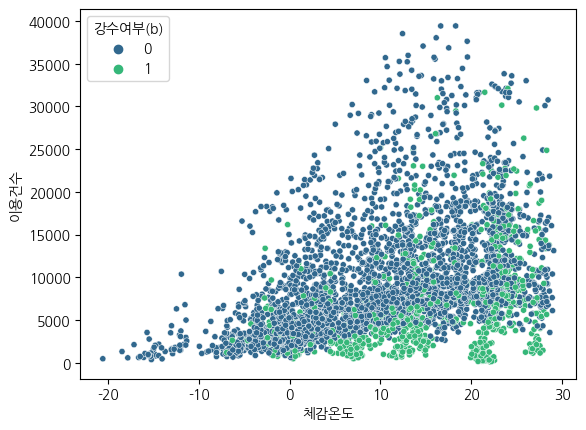

In [34]:
sns.scatterplot(x='체감온도', y='이용건수', hue='강수여부(b)', data=merged_grouped_df, palette='viridis', s=20)
plt.show()

근데 솔직히 아직 잘 모르겠는 게, 체감온도가 과도하게 높은 경우에도 문제가 되는 거 아닌가 싶다. 이걸 확인하려면 혹서기 데이터를 볼 수 있어야 하는데 나는 6개월치 데이터만 쓰고 있어서 지금 해당 범위가 빠져있다...

### 3-2. 가설 검정 (날씨가 좋은 날)

#### 3-2-1. 가설 설정

'날씨가 좋은 날'의 기준은 다음을 모두 만족하는 날로 정한다.
- 하루 평균 체감온도가 10도 이상, 25도 이하인 날
- 하루 중 강수가 전혀 없는 날

이제 귀무가설과 대립가설을 다음과 같이 세울 수 있다.
- $H_0$: 날씨가 좋은 날의 '이용건수' 평균과 그 외의 날의 '이용건수' 평균 사이에는 차이가 없다.
- $H_1$: 날씨가 좋은 날의 '이용건수' 평균은 그 외의 날의 '이용건수' 평균보다 크다.

In [35]:
good_weather_df = merged_grouped_df[
    (merged_grouped_df['체감온도'] >= 10) & (merged_grouped_df['체감온도'] <= 25) &
    (merged_grouped_df['강수여부(b)'] == 0)
]

good_weather_df

,그룹명,대여년월,이용건수,강수여부,체감온도,기온(°C),풍속(m/s),강수여부(b)
65,강남구,2023-03-07,8001,0.0,11.745833,11.745833,1.270833,0
66,강남구,2023-03-08,7858,0.0,12.758333,12.758333,1.033333,0
68,강남구,2023-03-10,8037,0.0,13.391667,13.391667,1.016667,0
69,강남구,2023-03-11,7195,0.0,15.083333,15.083333,1.158333,0
79,강남구,2023-03-21,8568,0.0,12.587500,12.587500,0.825000,0
...,...,...,...,...,...,...,...,...
4482,중랑구,2023-06-12,10755,0.0,23.793772,23.225000,1.429167,0
4483,중랑구,2023-06-13,11976,0.0,23.431976,23.200000,1.958333,0
4485,중랑구,2023-06-15,12013,0.0,23.662027,23.216667,1.666667,0
4486,중랑구,2023-06-16,11947,0.0,24.701112,24.716667,2.020833,0


In [36]:
not_good_weather_df = merged_grouped_df[
    (merged_grouped_df['체감온도'] < 10) | (merged_grouped_df['체감온도'] > 25) |
    (merged_grouped_df['강수여부(b)'] == 1)
]

not_good_weather_df

,그룹명,대여년월,이용건수,강수여부,체감온도,기온(°C),풍속(m/s),강수여부(b)
0,강남구,2023-01-01,1879,0.0,0.901465,0.937500,1.525000,0
1,강남구,2023-01-02,3082,0.0,-2.987500,-2.987500,1.500000,0
2,강남구,2023-01-03,3301,0.0,-3.724754,-3.695833,1.216667,0
3,강남구,2023-01-04,3989,0.0,-1.366667,-1.366667,0.941667,0
4,강남구,2023-01-05,3912,0.0,-1.970833,-1.970833,0.683333,0
...,...,...,...,...,...,...,...,...
4495,중랑구,2023-06-25,8395,0.0,28.588273,28.333333,1.725000,0
4496,중랑구,2023-06-27,10158,279.0,26.690446,25.970833,2.558333,1
4497,중랑구,2023-06-28,10871,0.0,28.101424,27.079167,2.233333,0
4498,중랑구,2023-06-29,2130,1116.0,27.160036,24.616667,2.366667,1


#### 3-2-2. 정규성 검정

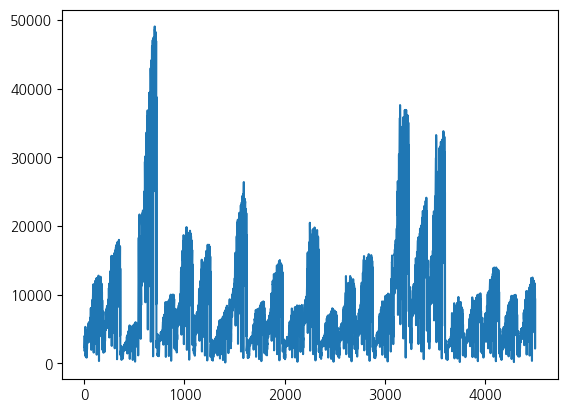

In [37]:
merged_grouped_df['이용건수'].plot(kind='line')
plt.show()

Q-Q plot이니 Shapiro-Wilk 정규성 검정이니 안 해봐도 대충 그래프 찍어보니까 정규성이 너무 없어 보인다... 굳이 여기서 정규성 검정을 더 들어가는 건 시간 낭비일 것 같으니 과감히 생략한다.

#### 3-2-3. 비모수적 검정

정규성 안 따르는 표본이면 비모수적 검정을 해야 한다. Mann-Whitney U 검정을 수행한다.

In [38]:
_, p_value_orders = stats.mannwhitneyu(good_weather_df['이용건수'], not_good_weather_df['이용건수'])

print("유의한 차이가 있음" if p_value_orders < 0.05 else "차이가 없음")

유의한 차이가 있음


In [39]:
good_weather_df['이용건수'].mean() - not_good_weather_df['이용건수'].mean()

5539.304038224599

날씨가 좋은 날의 이용건수와 그 외의 날의 이용건수 사이에 유의한 차이가 있다는 결론을 얻었다. 날씨가 좋은 날의 이용건수 평균이 훨씬 높기 때문에, **날씨가 좋은 날에 공공자전거를 더 많이 이용한다**는 결론을 얻을 수 있다.

사실 그리 놀라운 결과는 아니다. 날씨가 좋은 날에는 당연히 자전거를 더 많이 탈 것이다. 근데 이게 순전히 온도 차이에 의한 것인지, 혹은 강수 여부에 의한 것인지는 아직 모르겠다. 각각을 분리해서 확인해 보면 확실해질 것이다.

### 3-3. 가설 검정 (비오는 날)

#### 3-3-1. 가설 설정

이번에는 '비오는 날'과 그렇지 않은 날을 비교해 본다.
- 하루 중 강수가 있는 날

이제 귀무가설과 대립가설을 다음과 같이 세울 수 있다.
- $H_0$: 비오는 날의 '이용건수' 평균과 비 안 오는 날의 '이용건수' 평균 사이에는 차이가 없다.
- $H_1$: 비오는 날의 '이용건수' 평균은 비 안 오는 날의 '이용건수' 평균보다 크다.

In [40]:
rainy_weather_df = merged_grouped_df[
    (merged_grouped_df['강수여부(b)'] == 1)
]

rainy_weather_df

,그룹명,대여년월,이용건수,강수여부,체감온도,기온(°C),풍속(m/s),강수여부(b)
5,강남구,2023-01-06,3766,320.0,0.183333,0.183333,0.983333,1
6,강남구,2023-01-07,2213,312.0,2.258333,2.258333,1.241667,1
12,강남구,2023-01-13,1176,1628.0,6.958333,6.958333,0.383333,1
13,강남구,2023-01-14,1331,918.0,6.812500,6.812500,0.745833,1
14,강남구,2023-01-15,987,1200.0,1.020833,1.020833,1.420833,1
...,...,...,...,...,...,...,...,...
4491,중랑구,2023-06-21,4497,1023.0,22.787718,20.354167,1.737500,1
4492,중랑구,2023-06-22,10663,93.0,23.733012,22.658333,1.800000,1
4496,중랑구,2023-06-27,10158,279.0,26.690446,25.970833,2.558333,1
4498,중랑구,2023-06-29,2130,1116.0,27.160036,24.616667,2.366667,1


In [41]:
not_rainy_weather_df = merged_grouped_df[
    (merged_grouped_df['강수여부(b)'] == 0)
]

not_rainy_weather_df

,그룹명,대여년월,이용건수,강수여부,체감온도,기온(°C),풍속(m/s),강수여부(b)
0,강남구,2023-01-01,1879,0.0,0.901465,0.937500,1.525000,0
1,강남구,2023-01-02,3082,0.0,-2.987500,-2.987500,1.500000,0
2,강남구,2023-01-03,3301,0.0,-3.724754,-3.695833,1.216667,0
3,강남구,2023-01-04,3989,0.0,-1.366667,-1.366667,0.941667,0
4,강남구,2023-01-05,3912,0.0,-1.970833,-1.970833,0.683333,0
...,...,...,...,...,...,...,...,...
4489,중랑구,2023-06-19,10931,0.0,28.374277,28.845833,1.983333,0
4493,중랑구,2023-06-23,11661,0.0,25.363608,24.304167,1.550000,0
4494,중랑구,2023-06-24,10037,0.0,27.407748,26.975000,1.704167,0
4495,중랑구,2023-06-25,8395,0.0,28.588273,28.333333,1.725000,0


#### 3-3-2. 비모수적 검정

아까 정규성 안 따르는 표본인 거 봤으니까 이번에도 비모수적 검정을 수행한다. 마찬가지로 Mann-Whitney U 검정을 수행한다.

In [42]:
_, p_value_orders = stats.mannwhitneyu(rainy_weather_df['이용건수'], not_rainy_weather_df['이용건수'])

print("유의한 차이가 있음" if p_value_orders < 0.05 else "차이가 없음")

유의한 차이가 있음


In [43]:
rainy_weather_df['이용건수'].mean() - not_rainy_weather_df['이용건수'].mean()

-2758.938644037913

비오는 날의 이용건수와 비 안 오는 날의 이용건수 사이에 유의한 차이가 있다는 결론을 얻었다. 비 안 오는 날의 이용건수 평균이 훨씬 높기 때문에, **비오는 날에 공공자전거를 더 적게 이용한다**는 결론을 얻을 수 있다.

### 3-4. 가설 검정 (적정 온도인 날)

#### 3-3-1. 가설 설정

이번에는 '적정 온도인 날'과 그렇지 않은 날을 비교해 본다.
- 하루 평균 체감온도가 10도 이상, 25도 이하인 날

이제 귀무가설과 대립가설을 다음과 같이 세울 수 있다.
- $H_0$: 적정 온도인 날의 '이용건수' 평균과 그렇지 않은 날의 '이용건수' 평균 사이에는 차이가 없다.
- $H_1$: 적정 온도인 날의 '이용건수' 평균은 그렇지 않은 날의 '이용건수' 평균보다 크다.

In [44]:
good_temperature_df = merged_grouped_df[
    (merged_grouped_df['체감온도'] >= 10) & (merged_grouped_df['체감온도'] <= 25)
]

good_temperature_df

,그룹명,대여년월,이용건수,강수여부,체감온도,기온(°C),풍속(m/s),강수여부(b)
65,강남구,2023-03-07,8001,0.0,11.745833,11.745833,1.270833,0
66,강남구,2023-03-08,7858,0.0,12.758333,12.758333,1.033333,0
67,강남구,2023-03-09,6825,328.0,11.629167,11.629167,1.487500,1
68,강남구,2023-03-10,8037,0.0,13.391667,13.391667,1.016667,0
69,강남구,2023-03-11,7195,0.0,15.083333,15.083333,1.158333,0
...,...,...,...,...,...,...,...,...
4485,중랑구,2023-06-15,12013,0.0,23.662027,23.216667,1.666667,0
4486,중랑구,2023-06-16,11947,0.0,24.701112,24.716667,2.020833,0
4487,중랑구,2023-06-17,9930,0.0,24.738901,25.466667,1.520833,0
4491,중랑구,2023-06-21,4497,1023.0,22.787718,20.354167,1.737500,1


In [45]:
not_good_temperature_df = merged_grouped_df[
    (merged_grouped_df['체감온도'] < 10) | (merged_grouped_df['체감온도'] > 25)
]

not_good_temperature_df

,그룹명,대여년월,이용건수,강수여부,체감온도,기온(°C),풍속(m/s),강수여부(b)
0,강남구,2023-01-01,1879,0.0,0.901465,0.937500,1.525000,0
1,강남구,2023-01-02,3082,0.0,-2.987500,-2.987500,1.500000,0
2,강남구,2023-01-03,3301,0.0,-3.724754,-3.695833,1.216667,0
3,강남구,2023-01-04,3989,0.0,-1.366667,-1.366667,0.941667,0
4,강남구,2023-01-05,3912,0.0,-1.970833,-1.970833,0.683333,0
...,...,...,...,...,...,...,...,...
4495,중랑구,2023-06-25,8395,0.0,28.588273,28.333333,1.725000,0
4496,중랑구,2023-06-27,10158,279.0,26.690446,25.970833,2.558333,1
4497,중랑구,2023-06-28,10871,0.0,28.101424,27.079167,2.233333,0
4498,중랑구,2023-06-29,2130,1116.0,27.160036,24.616667,2.366667,1


#### 3-3-2. 비모수적 검정

아까 정규성 안 따르는 표본인 거 봤으니까 이번에도 비모수적 검정을 수행한다. 마찬가지로 Mann-Whitney U 검정을 수행한다.

In [46]:
_, p_value_orders = stats.mannwhitneyu(good_temperature_df['이용건수'], not_good_temperature_df['이용건수'])

print("유의한 차이가 있음" if p_value_orders < 0.05 else "차이가 없음")

유의한 차이가 있음


In [47]:
good_temperature_df['이용건수'].mean() - not_good_temperature_df['이용건수'].mean()

4769.768105073929

적정 온도인 날의 이용건수와 그렇지 않은 날의 이용건수 사이에 유의한 차이가 있다는 결론을 얻었다. 적정 온도인 날의 이용건수 평균이 훨씬 높기 때문에, **적정 온도인 날에 공공자전거를 더 많이 이용한다**는 결론을 얻을 수 있다.

## 4. 결론

이상의 분석 결과로부터, 적정 온도 범위 내, 강수가 없는 환경에서의 공공자전거 이용건수가 유의미하게 많음을 확인할 수 있었다.

API를 핸들링하는 부분부터 파생변수를 생성하여 분석에 이용하는 부분까지 폭넓게 다뤄볼 수 있는 프로젝트였다. 여러 개의 데이터셋을 조인하여 활용해야만 했기에 해당 과업에서의 스킬들을 익힐 수 있었던 점도 좋았다.

다만 정규분포를 안 따르는 데이터라서 비모수적 검정을 활용해야 했던 부분이 조금 아쉽다.

또한 악천후의 기준에 대해 어떻게 정의내릴지를 내가 임의로 판단해서 분석을 진행했는데, 관련 연구를 추가로 서칭하여 기준이 될 만한 수치들을 확인해 보는 과정이 선행되었다면 더 정교한 결과를 얻을 수 있었을 것 같아 아쉽다.

그리고 본 연구에서 활용한 데이터는 1월\~6월로 한정되어 있기 때문에 7\~8월 혹서기 기간 데이터를 추가로 투입하면 다른 결과를 낳을지도 모르겠다는 생각이 들었다. 추후 기회가 된다면 해당 부분도 개선하여 추가적으로 분석을 진행해 보아도 좋겠다.